In [1]:
from __future__ import print_function
import torch
from torchvision import datasets, transforms
import numpy as np
from WeakLearners import WongNeuralNetCIFAR10
import matplotlib.pyplot as plt
import os
from datetime import datetime

In [2]:
!pip install pytorch_memlab

You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
from Boosting import Ensemble, runBoosting
from AdversarialAttacks import attack_fgsm, attack_pgd
from pytorch_memlab import LineProfiler

In [4]:
import utils

In [5]:
cuda = torch.device('cuda:0')

In [6]:
%load_ext autoreload
%autoreload 2

## CIFAR10 Boosting (Adversarial)

In [7]:
# maxSamples_vals = [100000, 200000, 500000]
maxSamples_vals = [750006]
# maxSamples_vals = [30003]
# maxSamples_vals = [500000, 1000000]
# done for 50K, 100K
# maxSamples_vals = [1000000, 2000000]
# maxSamples_vals = [123456]
batch_size=100
# maxSamples_vals = [batch_size + 1]

In [8]:
num_wl = 6 # maybe around 100? #later: maybe change this to an array?
num_epochs = 1

In [9]:
ensembles = []
# epsilons = [0.0, 0.01, 0.02, 0.03, 0.05, 0.1]
epsilons = [0.127]
train_eps_nn = 8
# epsilons = []
# epsilons = [0.0, 0.01]

In [10]:
from Testing import testEnsemble
path = f'./models/{maxSamples_vals[0]}Eps{train_eps_nn}/'
attack=attack_pgd
attackStr="attack_pgd"
ensemble = testEnsemble(path, [attack], num_wl, numsamples_train=200, numsamples_val=1500, attack_eps_ensemble=epsilons, gradOptWeights=True) 

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Weak Learner  0 .  Time Elapsed (s):  0
weights before opt: [0.3465735902799726]
tensor before opt: tensor([[0.3466]], device='cuda:0')
weights after opt: [0.3575606346130371]
tensor after opt: tensor([[0.3576]], device='cuda:0')
{'val': 0.73, <function attack_pgd at 0x7f62f7b7f840>: [0.48]}
{'val': 0.7, <function attack_pgd at 0x7f62f7b7f840>: [0.42]}
{'val': 0.62, <function attack_pgd at 0x7f62f7b7f840>: [0.43]}
{'val': 0.69, <function attack_pgd at 0x7f62f7b7f840>: [0.46]}
{'val': 0.67, <function attack_pgd at 0x7f62f7b7f840>: [0.41]}
{'val': 0.68, <function attack_pgd at 0x7f62f7b7f840>: [0.41]}
{'val': 0.73, <function attack_pgd at 0x7f62f7b7f840>: [0.43]}
{'val': 0.63, <function attack_pgd at 0x7f62f7b7f840>: [0.41]}
{'val': 0.68, <function attack_pgd at 0x7f62f7b7f840>: [0.45]}
{'val': 0.69, <function attack_pgd at 0x7f62f7b7f840>: [0.5]}
{'val': 0.74, <function atta

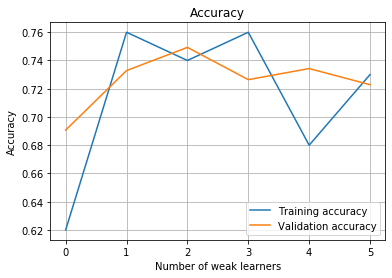

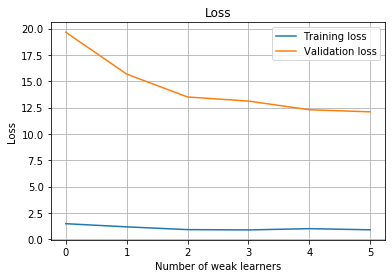

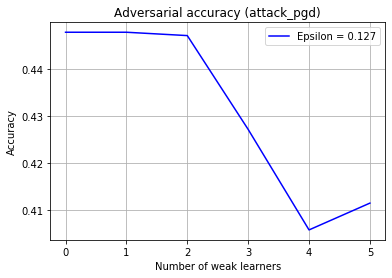

In [11]:
maxSamples = maxSamples_vals[0]
resultsPath = f'results/plots/cifar10/train_eps_{train_eps_nn}/{attackStr}/'
acc_file = resultsPath + f'acc_maxSamples_{maxSamples}.png'
adv_acc_file = resultsPath + f'adv_acc_maxSamples_{maxSamples}.png'
loss_file = resultsPath + f'loss_maxSamples_{maxSamples}.png'
# wl_train_acc_file = resultsPath + f'wl_train_acc_maxSamples_{maxSamples}.png'
ensemble.plot_accuracies(acc_file)
ensemble.plot_loss(loss_file)
ensemble.plot_adversarial_accuracies(adv_acc_file)
# ensemble.plot_wl_acc(wl_train_acc_file)


In [ ]:
# from Boosting import SchapireWongMulticlassBoosting
from AdversarialAttacks import attack_fgsm, attack_pgd
import gc
# Ensemble.record_accuracies, Ensemble.calc_accuracies, attack_fgsm, Ensemble.schapireContinuousPredict
for i in range(len(maxSamples_vals)):
    print("len(maxSamples_vals):", len(maxSamples_vals))
    maxSamples = maxSamples_vals[i]
    print("maxSamples:", maxSamples)
    ensemble = runBoosting(num_wl, maxSamples, dataset=datasets.CIFAR10, weakLearnerType = WongNeuralNetCIFAR10, val_attacks = [], 
                               attack_eps_nn=epsilons, attack_eps_ensemble=epsilons, train_eps_nn=train_eps_nn, adv_train_prefix=num_wl, batch_size=batch_size, val_flag=False)
    print("number of wl in ensemble:", len(ensemble.weakLearners))
    ensembles.append(ensemble)
    gc.collect()
#     for obj in gc.get_objects():
#         try:
#             if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
#                 print(type(obj), obj.size())
#         except:
#             pass
    
#     path_head = f'results/plots/cifar10/train_eps_{train_eps_nn}/'
#     try:
#         os.mkdir(path_head)
#     except OSError:
#         pass
#     acc_file = path_head + f'acc_maxSamples_{maxSamples}.png'
#     adv_acc_file = path_head + f'adv_acc_maxSamples_{maxSamples}.png'
#     loss_file = path_head + f'loss_maxSamples_{maxSamples}.png'
#     wl_train_acc_file = path_head + f'wl_train_acc_maxSamples_{maxSamples}.png'
#     ensemble.plot_accuracies(acc_file)
#     ensemble.plot_loss(loss_file)
#     ensemble.plot_adversarial_accuracies(adv_acc_file)
#     ensemble.plot_wl_acc(wl_train_acc_file)
#0.3445499534706232, 0.35256058576867955, 0.3492509840145725

## Sanity Checking PGD Attack

In [11]:
TestNN = WongNeuralNetCIFAR10(attack_eps=[0.127])

In [12]:
TestNN.model.load_state_dict(torch.load("./models/750004Eps8/wl_0.pth"))
TestNN.model.cuda()
TestNN.model.eval()
print("")

In [13]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616)),
])

# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616)),
])

trainset = datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=100, shuffle=True, num_workers=2)

testset = datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(
    testset, batch_size=1000, shuffle=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


### Check a single WL

In [14]:
i = 0
accs = []
for data in test_loader:
    X = data[0]
    y = data[1]
    losses, acc = TestNN.calc_accuracies(X.cuda(), y.cuda(), val_attacks=[attack_pgd], attack_iters=20)
    print(acc[attack_pgd][0])
    accs.append(acc[attack_pgd][0])
    
    if i>20:
        break
    i+=1
print("Overall acc: ", sum(accs)/len(accs))

0.387
0.379
0.402
0.389
0.38
0.396
0.394
0.378
0.414
0.403
Overall acc:  0.39220000000000005


## Sanity check for PGD (single weak learner and ensemble)

In [23]:
pgd_steps = [20, 40, 60, 80, 100]
# pgd_steps = [20]
attack_eps = [0.03]
num_wl = 1
from Testing import testEnsemble

In [24]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616)),
])

# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616)),
])

trainset = datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=100, shuffle=True, num_workers=2)

testset = datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(
    testset, batch_size=1000, shuffle=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [19]:
#Test pgd on weak learners
wl_accuracies = []
for attack_iters in pgd_steps:
    TestNN = WongNeuralNetCIFAR10(attack_eps=attack_eps)
    TestNN.model.load_state_dict(torch.load("./models/750000Eps8/wl_0.pth"))
    TestNN.model.cuda()
    TestNN.model.eval()
    print("")
    
    i = 0
#     accs = []
    for data in test_loader:
        X = data[0]
        y = data[1]
        losses, acc = TestNN.calc_accuracies(X.cuda(), y.cuda(), val_attacks=[attack_pgd], attack_iters=attack_iters)
        print(acc)
        wl_accuracies.append(acc[attack_pgd])

    #     if i>5:
        break
        i+=1
print("pgd_steps:", pgd_steps)
print("wl_accuracies:", wl_accuracies)
plt.subplots()
plt.plot(pgd_steps, wl_accuracies)
plt.xlabel('PGD iterations')
plt.ylabel('Accuracy')
plt.title('Weak learner accuracy vs PGD iterations')
plt.show()

RuntimeError: CUDA out of memory. Tried to allocate 126.00 MiB (GPU 0; 15.90 GiB total capacity; 14.80 GiB already allocated; 9.50 MiB free; 15.23 GiB reserved in total by PyTorch)

In [18]:
# Test pgd on ensemble (1 wl)
for attack_iters in pgd_steps:
    ensemble = Ensemble(weakLearners=[], weakLearnerWeights=[], weakLearnerType=WongNeuralNetCIFAR10, attack_eps=[0.03])
    ensemble.losses["val"]
    for i in range(1):
        ensemble.addWeakLearner("./models/750000Eps8/wl_0.pth", 1)
#         print("before ens acc", ensemble.accuracies)

        ensemble.record_accuracies(i, train_loader, test_loader, 1000, 1000, val_attacks=[attack_pgd], attack_iters=attack_iters)
        print("ensemble accuracies:", ensemble.accuracies)

KeyError: 'val'

In [16]:
accuracies = []

In [25]:
# test pgd on ensemble (more wl)
num_wl = 15
train_eps_nn = 8
for attack_iters in pgd_steps:
    path = f'./models/{maxSamples_vals[0]}Eps{train_eps_nn}/'
    attack=attack_pgd
    attackStr="attack_pgd"
    ensemble = testEnsemble(path, [attack], num_wl, numsamples_train=400, numsamples_val=400, attack_eps_ensemble=epsilons, attack_iters=attack_iters)
    accuracies.append(ensemble.accuracies[attackStr])
    print("cur acc:", accuracies[-1])
    
    
#     maxSamples = maxSamples_vals[0]
#     resultsPath = f'results/plots/cifar10/train_eps_{train_eps_nn}_iter_{attack_iters}/{attackStr}/'
#     acc_file = resultsPath + f'acc_maxSamples_{maxSamples}.png'
#     adv_acc_file = resultsPath + f'adv_acc_maxSamples_{maxSamples}.png'
#     loss_file = resultsPath + f'loss_maxSamples_{maxSamples}.png'
#     # wl_train_acc_file = resultsPath + f'wl_train_acc_maxSamples_{maxSamples}.png'
#     ensemble.plot_accuracies(acc_file)
#     ensemble.plot_loss(loss_file)
#     ensemble.plot_adversarial_accuracies(adv_acc_file)
    # ensemble.plot_wl_acc(wl_train_acc_file)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Weak Learner  0 .  Time Elapsed (s):  0
Weak Learner  1 .  Time Elapsed (s):  0
Weak Learner  2 .  Time Elapsed (s):  0
Weak Learner  3 .  Time Elapsed (s):  0
pgd called with 0.127 0.01 20 1
{'val': 0.71, <function attack_pgd at 0x7f20b4390400>: [0.39]}
pgd called with 0.127 0.01 20 1
{'val': 0.73, <function attack_pgd at 0x7f20b4390400>: [0.41]}
pgd called with 0.127 0.01 20 1
{'val': 0.74, <function attack_pgd at 0x7f20b4390400>: [0.47]}
ensemble accuracies: {'train': [0.7466666666666667], 'val': [0.7266666666666666], 'attack_fgsm': [], 'attack_pgd': [[0.42333333333333334]], 'wl_train': [], 'wl_val': []}
Weak Learner  4 .  Time Elapsed (s):  60
Weak Learner  5 .  Time Elapsed (s):  60
Weak Learner  6 .  Time Elapsed (s):  60
Weak Learner  7 .  Time Elapsed (s):  60
Weak Learner  8 .  Time Elapsed (s):  60
Weak Learner  9 .  Time Elapsed (s):  60
Weak Learner  10 .  Time 

NameError: name 'accuracies' is not defined

In [ ]:
print(accuracies)